In [1]:
import numpy as np
import pickle
import matplotlib.pylab as plt, matplotlib
import pandas
import scipy.stats
import gzip

import sys
from scipy import interpolate
#sys.path.insert(1, "../bgs_prediction/")
#from bmap_prediction import *

# dictionary with keys (u, s), storing means and standard deviations across simulations
with open("../simulation_outputs/combined_data.freeze.pkl", "rb") as fin:
    data = pickle.load(fin)

from mpl_toolkits.axes_grid1 import make_axes_locatable
# set font sizes
plt.rcParams["legend.title_fontsize"] = "xx-small"
matplotlib.rc("xtick", labelsize=7)
matplotlib.rc("ytick", labelsize=7)
matplotlib.rc("axes", labelsize=8)
matplotlib.rc("axes", titlesize=8)
matplotlib.rc("legend", fontsize=6)
plt.rcParams['legend.title_fontsize'] = 'xx-small'

In [2]:
import bgshr

In [3]:
## for comparisons in panels A and B, need to distinguish between moments and classic BGS, without extending the table.
df_name = "../lookup_tables/lookup_tbl_equilibrium.csv.gz"
#df = pandas.read_csv(df_name)
#df_sub = df[(df["Na"] == 10000) & (df["uL"] == 1e-8)]
df = bgshr.Util.load_lookup_table(df_name)
df_sub = bgshr.Util.subset_lookup_table(df)

In [4]:
smax = 0.005
s_extend = -np.logspace(0, np.log10(smax), 40)

In [5]:
u_vals, s_vals, splines = bgshr.Util.generate_cubic_splines(df_sub)

In [6]:
# Set up chromosome
L = 1e5
L_elem = 1000
n_elem = int(L / L_elem)
x_elem = np.arange(L_elem / 2, L, L_elem)

elements = [[a, b] for a, b in zip(np.linspace(0, L, n_elem + 1)[:-1], np.linspace(0, L, n_elem + 1)[1:])]

# The grid of positions that we compute B values at
xx = xs = np.linspace(0, L, 101)

In [7]:
Ne = 1e4
r = 1e-8
rmap = bgshr.Util.build_uniform_rmap(r, L)

In [8]:
us = [1e-9, 3e-9, 6e-9, 1e-8, 3e-8]
ss = [-0.001, -0.0005, -0.0002, -0.0001, -0.00005, -0.00002, -0.00001]


color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {u: c for u, c in zip(us, color_cycle[:len(us)])}

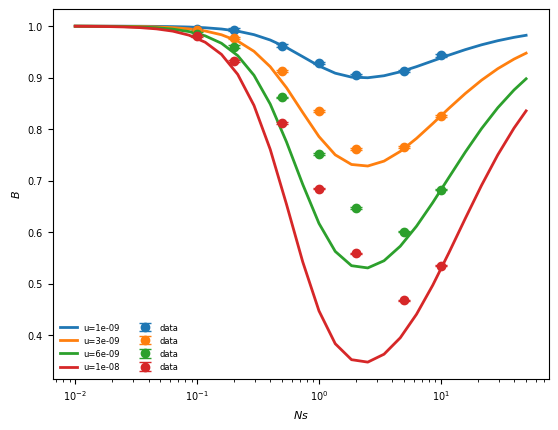

In [9]:
for u in us[:-1]:
    x = s_vals[-2::-1]
    y = [bgshr.Predict.Bvals([50000], s, splines, u=u, L=L, rmap=rmap, elements=elements) for s in x]
    #y = [get_Bmap_uniform(xx, x_elem, L_elem, u_vals, s_vals, splines, s=s, u=u)(L / 2) for s in x]
    plt.plot(-Ne * x, y, color=colors[u], lw=2, label=f"u={u}")
    x = np.array([-Ne*s for s in ss])
    z = [data[(u, s)]["mean"][50] for s in ss]
    e = [data[(u, s)]["std"][50] for s in ss]
    plt.errorbar(x, z, yerr=e, color=colors[u], ls='', marker='o', capsize=4, capthick=1, label="data")

plt.xscale("log")
plt.ylabel("$B$")
plt.xlabel("$Ns$")
plt.legend(ncol=2, frameon=False);

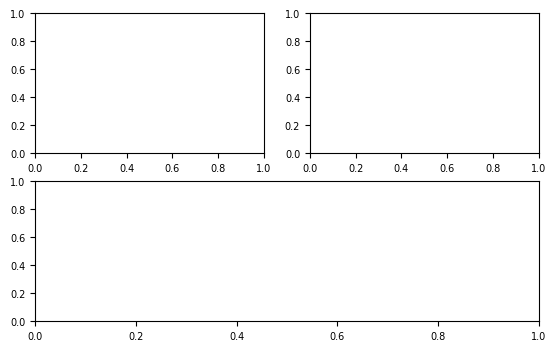

In [10]:
fig = plt.figure(1, figsize=(6.5, 4))
fig.clf()
ax = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)

In [11]:
n_iter = 10

for u in us[:-1]:
    print(u, end=": ")
    x = s_vals[-2::-1]
    y = []
    y0 = []
    for s in x:
        #print(f"{s:0.6f}", end=" ")
        bmaps = [bgshr.Predict.Bmap(xs, s, splines, u=u, L=L, rmap=rmap, elements=elements)]
        y0.append(bmaps[0](L / 2))
        for i in range(n_iter):
            rmap2 = bgshr.Util.adjust_uniform_rmap(r, L, bmap=bmaps[-1])
            bmaps.append(bgshr.Predict.Bmap(xs, s, splines, u=u, L=L, rmap=rmap2, elements=elements, bmap=bmaps[-1]))
        y.append(bmaps[-1](L / 2))    
    ax.plot(-Ne * x, y0, "-", color=colors[u], lw=1, label=u)
    ax.plot(-Ne * x, y, "--", color=colors[u], lw=1.5)
    x2 = [-Ne*s for s in ss]
    z = [data[(u, s)]["mean"][50] for s in ss]
    e = [data[(u, s)]["std"][50] for s in ss]
    #ax.errorbar(x, z, yerr=e, color=colors[u], ls='', marker='o', ms=4, capsize=4, capthick=1)
    ax.plot(x2, z, "o", color=colors[u], ms=4, markeredgewidth=0.5, markeredgecolor="white")

    s_bgs = np.logspace(-4.8, -1, 101)
    bgs = [bgshr.ClassicBGS.classic_BGS([L / 2], -s, u, L=L, rmap=rmap, elements=elements)[0] for s in s_bgs]
    ax.plot(Ne * s_bgs, bgs, ":", lw=1)
    print("done")

1e-09: done
3e-09: done
6e-09: done
1e-08: done


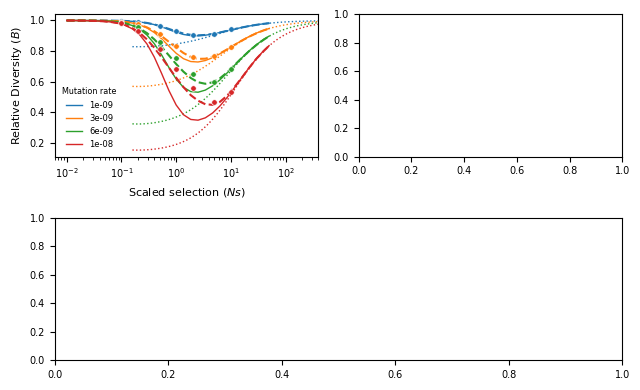

In [12]:
ax.legend(title="Mutation rate", frameon=False)
ax.set_xscale("log")
ax.set_ylabel("Relative Diversity ($B$)")
ax.set_xlabel("Scaled selection ($Ns$)")
ax.set_xlim(0.006, 400)

fig.tight_layout()
fig

In [13]:
df = bgshr.Util.load_lookup_table(df_name)
df_sub = bgshr.Util.subset_lookup_table(df)
df_sub = bgshr.ClassicBGS.extend_lookup_table(df_sub, s_extend)

u_vals, s_vals, splines = bgshr.Util.generate_cubic_splines(df_sub)

In [14]:
shape = 0.215
scale = 562.1 / 2 / Ne
mean = shape * scale

print("mean s:", mean)

weights = bgshr.Util.weights_gamma_dfe(s_vals, shape, scale)
print("total weights:", weights[:-1].sum())

mean s: 0.0060425750000000005
total weights: 0.9003955137635471


In [15]:
uL = 1e-8

Bs = bgshr.Predict.Bvals(xs, s_vals[:-1], splines, L=L, rmap=rmap, elements=elements)
B_high = np.prod([Bs[i] ** (weights[i] * 1e-8 / uL) for i in range(len(Bs))], axis=0)
B_low = np.prod([Bs[i] ** (weights[i] * 3e-9 / uL) for i in range(len(Bs))], axis=0)

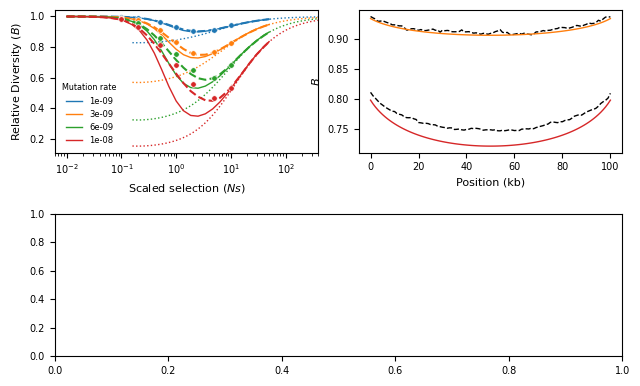

In [16]:
data_dfe_high_mu = np.load("../simulation_outputs/DFE.u_1e-08.Q_5.npz")["arr_0"]
data_dfe_low_mu = np.load("../simulation_outputs/DFE.u_3e-09.Q_5.npz")["arr_0"]
ax2.clear()
ax2.plot(xs / 1000, data_dfe_low_mu, "k--", lw=1, markeredgecolor="white", label=None)
ax2.plot(xs / 1000, data_dfe_high_mu, "k--", lw=1, markeredgecolor="white", label=None)
ax2.plot(xs / 1000, B_low, lw=1, label=f"pred. (u={3e-9})", color=color_cycle[1])
ax2.plot(xs / 1000, B_high, lw=1, label=f"pred. (u={1e-8})", color=color_cycle[3])
ax2.set_xlabel("Position (kb)")
ax2.set_ylabel("$B$")
fig

In [17]:
for i in range(n_iter):
    print(i, end="  ")
    bmap = scipy.interpolate.CubicSpline(xs, B_high, bc_type="natural")
    rmap_updated = bgshr.Util.adjust_recombination_map(rmap, bmap)
    Bs_high = bgshr.Predict.Bvals(xs, s_vals[:-1], splines, L=L, rmap=rmap_updated, elements=elements, bmap=bmap)
    B_high = np.prod([B ** (w * 1e-8 / uL) for B, w in zip(Bs_high, weights[:-1])], axis=0)
print("done with u=1e-8")

for i in range(n_iter):
    print(i, end="  ")
    bmap = scipy.interpolate.CubicSpline(xs, B_low, bc_type="natural")
    rmap_updated = bgshr.Util.adjust_recombination_map(rmap, bmap)
    Bs_low = bgshr.Predict.Bvals(xs, s_vals[:-1], splines, L=L, rmap=rmap_updated, elements=elements, bmap=bmap)
    B_low = np.prod([B ** (w * 3e-9 / uL) for B, w in zip(Bs_low, weights[:-1])], axis=0)
print("done with u=3e-9")

0  1  2  3  4  5  6  7  8  9  done with u=1e-8
0  1  2  3  4  5  6  7  8  9  done with u=3e-9


In [18]:
ax2.plot(xs / 1000, B_low, "--", lw=1.5, label="interf. corr.",  color=color_cycle[1])
ax2.plot(xs / 1000, B_high, "--", lw=1.5, label="interf. corr.", color=color_cycle[3])

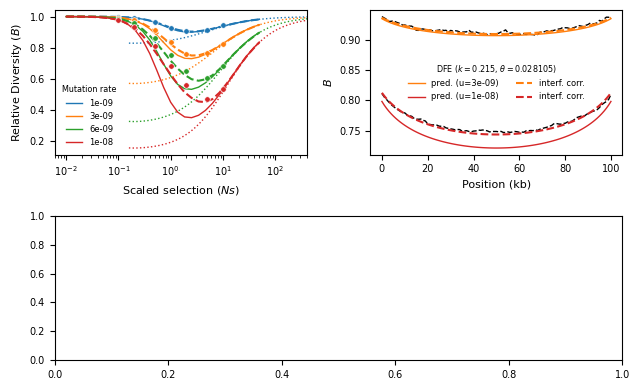

In [19]:
ax2.legend(title=rf"DFE ($k={shape}$, $\theta={scale}$)", frameon=False, ncol=2, loc="center")
#ax2.set_ylim(bottom=0.7,top=1.15)
fig.tight_layout()
fig

In [20]:
### %timeit bgshr.Predict.Bvals(xs, s_vals[20], 1e-8, splines, L=L, rmap=rmap_updated, elements=elements)

In [21]:
#%timeit bgshr.Predict.Bvals(xs, s_vals[20], 1e-8, splines, L=L, rmap=rmap_updated, elements=elements, bmap=bmap)

In [22]:
Lsel = 100000
Lneu = 10000000
Ltot = Lsel + Lneu
u = 1e-8

x_extend = np.arange(-Lsel, Lneu + 1, 1000)

In [23]:
s_sims = [-0.01, -0.001, -0.0001, -0.00001]
Q = 1
fname = f"../simulation_outputs/extended_sim_data.Q_{Q}.Ne_10000.u_3e-09.pkl.gz"
try:
    extended_sims = pickle.load(gzip.open(fname, "rb"))
except IOError:
    extended_sims = {}
    for s in s_sims:
        c = 1
        reps = np.loadtxt(f"replicates/diversity_average.extended.seed_1.Ne_10000.s_{s}.u_1e-08.Q_{float(Q)}.txt")
        for i in range(2, 10001):
            try:
                reps += np.loadtxt(f"replicates/diversity_average.extended.seed_{i}.Ne_10000.s_{s}.u_1e-08.Q_{float(Q)}.txt")
                c += 1
            except IOError:
                continue
        
        print("sel", s,"... found", c)
        reps /= c
        reps /= 4 * Ne / Q
        extended_sims[s] = reps
    with gzip.open(fname, "wb+") as fout:
        pickle.dump(extended_sims)

In [24]:
max_x = {-0.01: 10000000, -0.001: 1000000, -0.0001: 400000, -0.00001: 100000}

In [25]:
ax3.clear()
ax3.set_xscale('linear')
ax3.set_xlim((-100, 0))
ax3.spines['right'].set_visible(False)
ax3.set_xticks([])
for s in s_sims:
    sim = extended_sims[s]
    ax3.plot(x_extend / 1000, sim, "-", lw=3, alpha=0.25)

divider = make_axes_locatable(ax3)
axLog = divider.append_axes("right", size=3.5, pad=0.1, sharey=ax3)
axLog.clear()

for s in s_sims:
    sim = extended_sims[s]
    i_max = np.where(x_extend < max_x[s])[0][-1] + 1
    axLog.plot(x_extend[101:i_max] / 1000, sim[101:i_max], "-", lw=3, alpha=0.25, label=f"sim. (s={s})")

axLog.set_xscale('log')
axLog.set_xlim((1, 1e4))
axLog.spines['left'].set_visible(False)
axLog.yaxis.set_ticks_position('right')
plt.setp(axLog.get_xticklabels(), visible=True)
axLog.yaxis.set_visible(False)

In [26]:
rmap_extend = bgshr.Util.build_uniform_rmap(r, Ltot)
bgs = np.zeros(len(extended_sims[-0.01]))
for i, s in enumerate(s_sims[:1]):
    bgs = bgshr.ClassicBGS.classic_BGS(x_extend + 100000, s, 3e-9, rmap=rmap_extend, elements=elements)
    ax3.plot(x_extend[:101] / 1000, bgs[:101], ":", lw=1, color=color_cycle[i])
    axLog.plot(x_extend[101:] / 1000, bgs[101:], ":", lw=1, color=color_cycle[i], label="pred. (classic)")

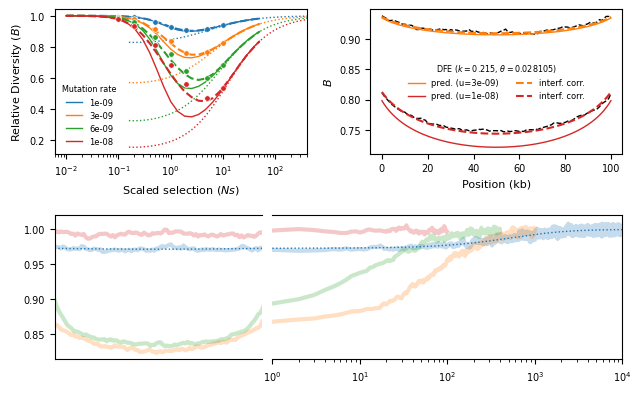

In [27]:
fig

In [28]:
n_iter = 8
for i, s in enumerate(s_sims[1:]):
    print(i)
    i_max = np.where(x_extend < max_x[s])[0][-1] + 1
    bvals = bgshr.Predict.Bvals(x_extend + 100000, s, splines, u=3e-9, rmap=rmap_extend, elements=elements)
    
    ax3.plot(x_extend[:101] / 1000, bvals[:101], lw=1, color=color_cycle[i+1])
    axLog.plot(x_extend[101:i_max] / 1000, bvals[101:i_max], lw=1, color=color_cycle[i+1], label="pred. (moments)")
    
    for j in range(n_iter):
        bmap = interpolate.CubicSpline(x_extend + 100000, bvals, bc_type="natural")
        rmap2 = bgshr.Util.adjust_uniform_rmap(r, Ltot, bmap, steps=10000)
        bvals = bgshr.Predict.Bvals(x_extend + 100000, s, splines, u=3e-9, rmap=rmap2, elements=elements, bmap=bmap)
    
    ax3.plot(x_extend[:101] / 1000, bvals[:101], "--", lw=1, color=color_cycle[i+1])
    axLog.plot(x_extend[101:i_max] / 1000, bvals[101:i_max], "--", lw=1, color=color_cycle[i+1])

0
1
2


In [29]:
axLog.legend(frameon=False, loc="lower right", ncol=2)
ax3.set_xlabel("Constrained region (100 kb)", labelpad=20)
axLog.set_xlabel("Distance from constrained region (kb)", labelpad=4)
ax3.set_ylabel("$B$")

Text(17.875, 0.5, '$B$')

In [30]:
fig.tight_layout()
fig.text(0.01, 0.98, "A", fontsize=10, va="center", ha="center")
fig.text(0.51, 0.98, "C", fontsize=10, va="center", ha="center")
fig.text(0.01, 0.5, "B", fontsize=10, va="center", ha="center")

fig.savefig(f"validation-steady-state.Q_{Q}.pdf")

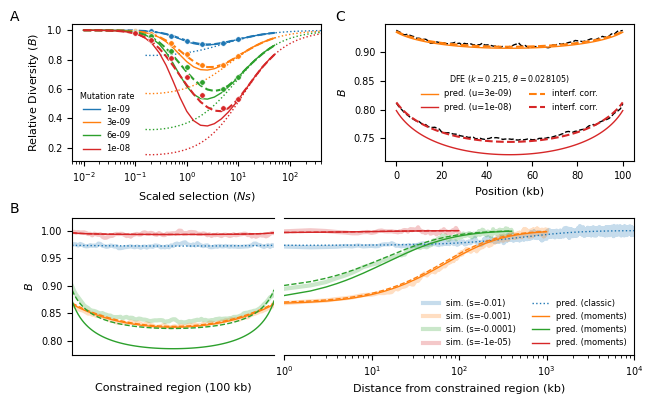

In [31]:
fig